In [1]:
import sys
sys.path.append("../src")
import pandas as pd
import ann_model as ann
import numpy as np
from ase.data import atomic_numbers
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

elements = list(atomic_numbers.keys())

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_pickle("../data/all_data.xz")

In [6]:
dfx = df.drop(columns = ['time_per_call', 'n_calls', 'normalized_time_per_call', 'convergence'] + elements).astype('float')
dfy = df['normalized_time_per_call'].astype('float')
# dfx.arch = 10
model = ann.TimePerCall(nvars = len(dfx.columns))
ind_tr, ind_val = ann.train_test_indices(dfx)
X_tr = dfx.loc[ind_tr]
Y_tr = dfy.loc[ind_tr]
X_val = dfx.loc[ind_val]
Y_val = dfy.loc[ind_val]
model.train_normed(X_tr, Y_tr)

Epoch 1/25
863/863 [==============================] - 1s 623us/step - loss: 0.5445 - mae: 0.5342 - val_loss: 0.2998 - val_mae: 0.2893
Epoch 2/25
863/863 [==============================] - 0s 515us/step - loss: 0.2937 - mae: 0.2832 - val_loss: 0.2256 - val_mae: 0.2151
Epoch 3/25
863/863 [==============================] - 1s 597us/step - loss: 0.2474 - mae: 0.2368 - val_loss: 0.1914 - val_mae: 0.1808
Epoch 4/25
863/863 [==============================] - 1s 635us/step - loss: 0.2226 - mae: 0.2120 - val_loss: 0.1720 - val_mae: 0.1614
Epoch 5/25
863/863 [==============================] - 1s 1ms/step - loss: 0.2059 - mae: 0.1953 - val_loss: 0.1519 - val_mae: 0.1413
Epoch 6/25
863/863 [==============================] - 2s 3ms/step - loss: 0.1932 - mae: 0.1826 - val_loss: 0.1404 - val_mae: 0.1298
Epoch 7/25
863/863 [==============================] - 5s 6ms/step - loss: 0.1846 - mae: 0.1740 - val_loss: 0.1345 - val_mae: 0.1239
Epoch 8/25
863/863 [==============================] - 6s 6ms/step - 

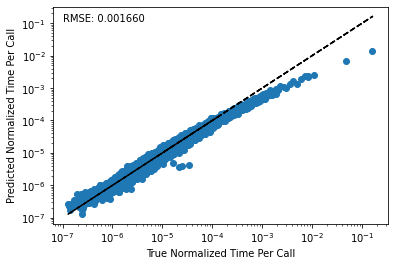

In [7]:
Y_hat = model.predict_normed(X_val)
plt.scatter(Y_val, Y_hat)
plt.plot(Y_val, Y_val, 'k--')
target = 'Normalized Time Per Call'
rmse = np.mean((Y_val.values - Y_hat[:, 0])**2)**0.5
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(1e-7, 0.7*max((Y_val)), "RMSE: %.6f" %(rmse))
plt.xscale('log')
plt.yscale('log')
plt.show()

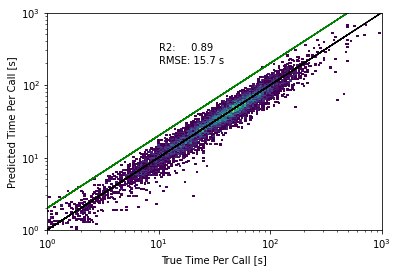

In [61]:
t_hat = Y_hat[:, 0] * X_val['n_el^3']*X_val['n_k']/X_val['n_cores']
t_val = df.loc[ind_val, 'time_per_call']
plt.hist2d(t_val, t_hat, bins = np.logspace(0, 3, 201), cmin = 0.01)
plt.plot(t_val, t_val, 'k-', lw=1)
plt.plot(t_val, 2*t_val, 'g-', lw=1)
target = 'Time Per Call [s]'
rmse = np.mean((t_val.values - t_hat)**2)**0.5
r2 = r2_score(t_val, t_hat)
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(10, 200, "RMSE: %.1f s" %(rmse))
plt.text(10, 300, "R2:     %.2f" %(r2))
plt.xscale('log')
plt.yscale('log')
plt.savefig("../../plots/ann_prediction_hpc.png")

In [7]:
model.save("model1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model1/assets


In [3]:
import optimizer as opt

In [4]:
df_ = df.loc[df.arch == 0]  # Use only data from Marconi
true_min, mean_time, time_with_pred_setup = [], [], []
pred_tpn, true_tpn, pred_np, true_np = [], [], [], []

for nel in df_.n_el.unique():
    for nn in df_.loc[df_.n_el == nel]['n_nodes'].unique():
        df__ = df_.loc[(df_.n_el == nel) & (df_.n_nodes == nn)]
        threads_per_node, nodes_per_pool = opt.optimize_from_df("optimizer.joblib", df__.iloc[0])
        n_pool = nn//nodes_per_pool
        true_min.append(df__['time_per_call'].min())
        mean_time.append(df__['time_per_call'].mean())
        minidx = df__['time_per_call'].idxmin()
        time_with_pred_setup.append(df__.loc[(df__.threads_per_node == threads_per_node) & (df__.n_pool == n_pool)]['time_per_call'].mean())
        true_np.append(df__.loc[minidx]['n_pool'])
        true_tpn.append(df__.loc[minidx]['threads_per_node'])
        pred_tpn.append(threads_per_node)
        pred_np.append(n_pool)
        
pred_tpn = np.array(pred_tpn)
pred_np = np.array(pred_np)
true_np = np.array(true_np)
true_min = np.array(true_min)
true_tpn = np.array(true_tpn)
mean_time = np.array(mean_time)
time_with_pred_setup = np.array(time_with_pred_setup)

In [26]:
time_with_pred_setup is np.nan

False

<ipython-input-28-cea96f79dd43>:3: RuntimeWarning: invalid value encountered in greater
  rmse = np.mean((true_min[time_with_pred_setup>0] - time_with_pred_setup[time_with_pred_setup>0])**2)**0.5
<ipython-input-28-cea96f79dd43>:4: RuntimeWarning: invalid value encountered in greater
  r2 = r2_score(true_min[time_with_pred_setup>0], time_with_pred_setup[time_with_pred_setup>0])


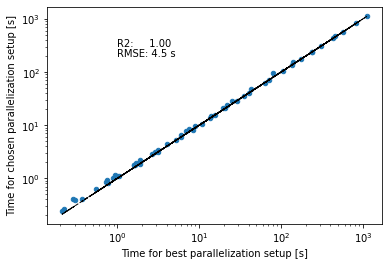

In [28]:
plt.scatter(true_min, time_with_pred_setup, s=20)
plt.plot(true_min, true_min, 'k--', lw=1)
rmse = np.mean((true_min[time_with_pred_setup>0] - time_with_pred_setup[time_with_pred_setup>0])**2)**0.5
r2 = r2_score(true_min[time_with_pred_setup>0], time_with_pred_setup[time_with_pred_setup>0])
plt.text(1, 200, "RMSE: %.1f s" %(rmse))
plt.text(1, 300, "R2:     %.2f" %(r2))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Time for best parallelization setup [s]")
plt.ylabel("Time for chosen parallelization setup [s]")
plt.savefig("../../plots/parallelization_optimization.png")

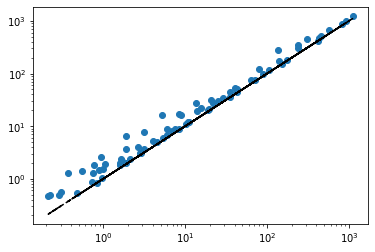

In [31]:
plt.scatter(true_min, mean_time)
plt.plot(true_min, true_min, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.show()

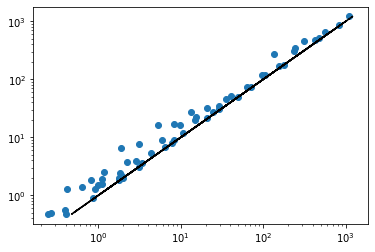

In [32]:
plt.scatter(time_with_pred_setup, mean_time)
plt.plot(mean_time, mean_time, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [83]:
df_ = df.loc[df.arch == 0].drop(columns = elements).drop(columns = ['convergence', 'n_transition', 'n_lanthanid', 'arch', 'n_el^3',
                                                                   'normalized_time_per_call', 'n_calls'])
tot = pd.DataFrame()
for nel in df_.n_el.unique():
    for nc in df_.loc[df_.n_el == nel]['n_cores'].unique():
        aa = df_.loc[(df_.n_el == nel) & (df_.n_cores == nc)]
        if len(aa) > 4:
            grouped = aa.groupby(by = ['threads_per_node', 'n_pool']).mean().reset_index()
            normfactor = grouped.time_per_call.min()
            grouped['norm_tpc'] = grouped.time_per_call/normfactor
            tot = tot.append(grouped.drop(columns = ['n_species', 'n_at', 'n_ks', 'time_per_call', 'n_g_smooth']))
            
tot['nodes_per_pool'] = tot.n_nodes/tot.n_pool
tot = tot.drop(columns = 'n_pool')

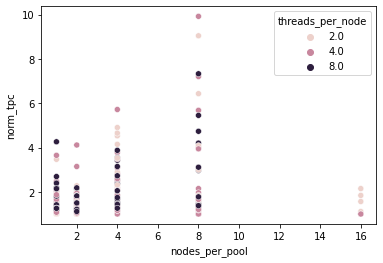

In [84]:
sns.scatterplot( data = tot, x = 'nodes_per_pool', hue = 'threads_per_node', y = 'norm_tpc', cmap = 'viridis')
plt.show()

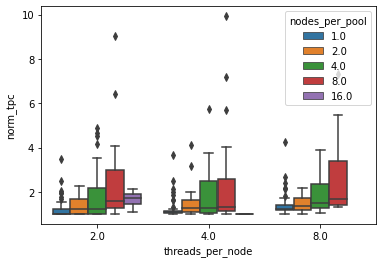

In [85]:
sns.boxplot( data = tot, x = 'threads_per_node', hue = 'nodes_per_pool', y = 'norm_tpc')
plt.show()

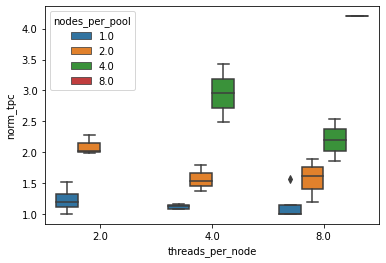

In [86]:
sns.boxplot( data = tot[tot.n_el == 80], x = 'threads_per_node', hue = 'nodes_per_pool', y = 'norm_tpc')
plt.show()

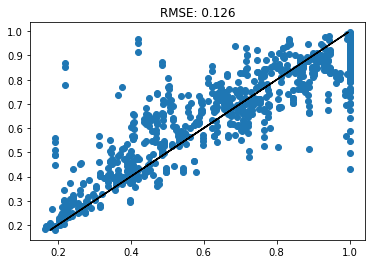

In [246]:
from sklearn.ensemble import RandomForestRegressor as rfr
import joblib

cross_vals = 10


def train_test_split(X, Y, split = 0.8):
    msk = np.random.rand(len(X)) < split
    return X[msk], Y[msk], X[~msk], Y[~msk]

df_ = df.loc[df.arch == 0].drop(columns = elements).drop(columns = ['convergence', 'n_transition', 'n_lanthanid', 'arch', 'n_el^3',
                                                                   'normalized_time_per_call', 'n_calls'])
tot = pd.DataFrame()
for nel in df_.n_el.unique():
    for nc in df_.loc[df_.n_el == nel]['n_cores'].unique():
        aa = df_.loc[(df_.n_el == nel) & (df_.n_cores == nc)]
        if len(aa) > 4:
            grouped = aa.groupby(by = ['threads_per_node', 'n_pool']).mean().reset_index()
            normfactor = grouped.time_per_call.min()
            grouped['norm_tpc'] = grouped.time_per_call/normfactor
            tot = tot.append(grouped.drop(columns = ['n_species', 'n_at', 'n_ks', 'time_per_call', 'n_g_smooth']))
            
tot['nodes_per_pool'] = tot.n_nodes/tot.n_pool
tot = tot.drop(columns = 'n_pool')
Y = np.exp(2/tot.norm_tpc.values)/np.e**2
X = np.log(tot.drop(columns = 'norm_tpc').values)
Y_vals, Y_hats = [], []
for r in np.arange(cross_vals):
    X_tr, Y_tr, X_val, Y_val = train_test_split(X, Y)
    regressor = rfr(min_samples_split=3).fit(X_tr, Y_tr)
    Y_hat = regressor.predict(X_val)
    Y_vals.extend(Y_val)
    Y_hats.extend(Y_hat)
Y_hats = np.array(Y_hats)
Y_vals = np.array(Y_vals)

joblib.dump(regressor, "./optimizer.joblib")


rmse = np.mean((Y_hats - Y_vals)**2)**0.5
plt.scatter(Y_vals, Y_hats)
plt.plot(Y_hats, Y_hats, 'k-')
plt.title("RMSE: %.3f" %(rmse))
plt.show()

In [217]:
import itertools
def predict_best(model, nel, nk, nbetas, nnodes, cores_per_node):
    tpns = np.array([2, 4, 8])
    ncores = nnodes*cores_per_node
    nodes_per_pool = np.array([1, 2, 4, 8, 16])
    x_ = np.array([a for a in itertools.product(tpns, nodes_per_pool)])
    X = np.zeros((len(x_), 5+x_.shape[1]))
    X[:, 0] = x_[:, 0]
    X[:, -1] = x_[:, 1]
    X[:, 1] = nel
    X[:, 2] = nk
    X[:, 3] = nbetas
    X[:, 4] = ncores
    X[:, 5] = nnodes
    scores = model.predict(np.log(X))
    scores[0] = scores[0]
    opt_tpns = X[np.argmax(scores)][0]
    opt_npp = X[np.argmax(scores)][-1]
    return opt_tpns, opt_npp

In [238]:
errors_tpn = 0
errors_npp = 0
i = 0
for nel in tot.n_el.unique():
    for nn in tot.loc[tot.n_el == nel]['n_nodes'].unique():
        aa = tot.loc[(tot.n_el == nel) & (tot.n_nodes == nn)]
        if len(aa) > 4:
            opt_tpn, opt_npp = predict_best(regressor, nel, aa.n_k.values[0], aa.n_betas.values[0], nn, 48)
            true_tpn = aa.loc[aa.norm_tpc.idxmin(), 'threads_per_node']
            true_npp = aa.loc[aa.norm_tpc.idxmin(), 'nodes_per_pool']
#             print("threads per node: %i - %i     Nodes per pool: %i - %i" %(opt_tpn, true_tpn, opt_npp, true_npp))
            errors_tpn += 1 - (opt_tpn == true_tpn)
            errors_npp += 1 - (opt_npp == true_npp)
            time_best = aa.loc[aa.norm_tpc.idxmin(), 'norm_tpc']
            time_opt = aa.loc[(aa.nodes_per_pool == opt_npp) & (aa.threads_per_node == opt_tpn), 'norm_tpc'].values
            if (opt_tpn !=true_tpn) or (opt_npp !=true_npp):
                print(time_best, time_opt)
            i +=1
print("Errors on estimation of thread per node: %.2f" %(errors_tpn/i))
print("Errors on estimation of  nodes per pool: %.2f" %(errors_npp/i))

1.0 [1.07802884]
1.0 [1.00669918]
1.0 [1.102935]
1.0 [1.00642283]
1.0 [1.06418724]
1.0 []
1.0 [1.03003337]
1.0 [1.10476314]
Errors on estimation of thread per node: 0.12
Errors on estimation of  nodes per pool: 0.12
